# Kalman filter strat
Basically attempting to implement this: https://www.reddit.com/r/algotrading/comments/obbb5d/kalman_filter_stat_arb/

With help from: 
https://github.com/welly87/epchanbooks/blob/main/book2/KF_beta_EWA_EWC.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [2]:
# BTCUSDT
# ETHUSDT
# DOTUSDT
# ADAUSDT
# LTCUSDT
# ZECUSDT
# XMRUSDT
# ETCUSDT
# XLMUSDT
# BCHUSDT
# EOSUSDT
# DASHUSDT
# NANOUSDT

In [3]:
# ZECUSDT, BCHUSDT

In [503]:
df1 = pd.read_csv("../data/ZECUSDT-hour.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/XMRUSDT-hour.csv", index_col=0, parse_dates=True)
# df3 = pd.read_csv("../data/LTCUSDT-hour.csv", index_col=0, parse_dates=True)

## Using the CADF Test for Cointegration

In [504]:
df = df1.close.rename("A").to_frame()
df["B"] = df2.close
# df["C"] = df3.close

In [505]:
df = df[1000:]
df = df.dropna()

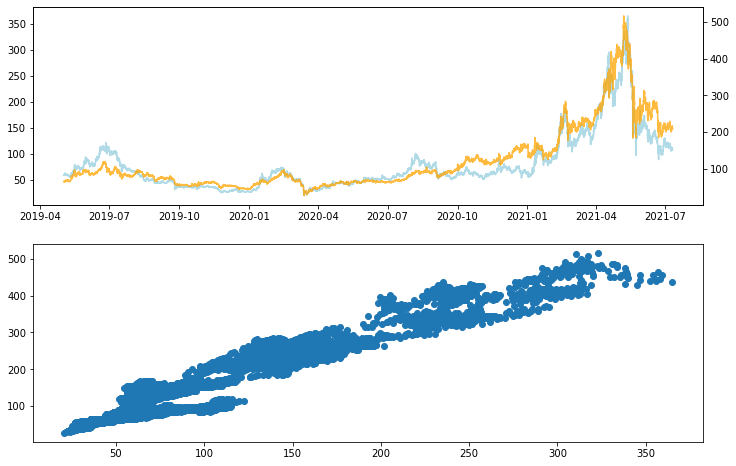

In [506]:
fig, (ax, ax1) = plt.subplots(2, figsize=(12, 8))
ax.plot(df[df.columns[0]], color="lightblue", alpha=.95)
axi = ax.twinx()
axi.plot(df[df.columns[1]], color="orange", alpha=.75)
ax1.scatter(df[df.columns[0]], df[df.columns[1]]);

In [507]:
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
print(results.params)
hedgeRatio = results.params[1]
print('hedgeRatio=%f' % hedgeRatio)

Intercept   -1.293929
A            1.526423
dtype: float64
hedgeRatio=1.526423


<AxesSubplot:xlabel='timestamp'>

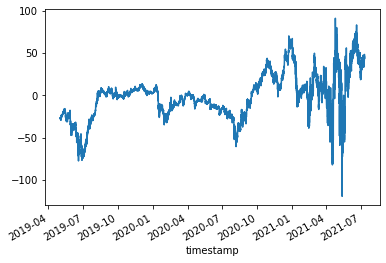

In [508]:
spread = pd.Series((df['B'] - hedgeRatio * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(100).mean()
spread["std"] =  spread.spread.rolling(100).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
spread.spread.plot()

<AxesSubplot:xlabel='timestamp'>

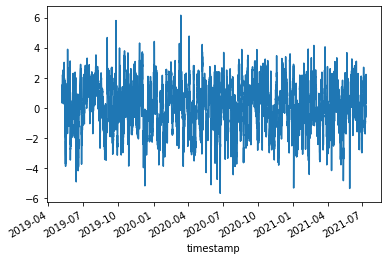

In [509]:
spread.zscore.plot()

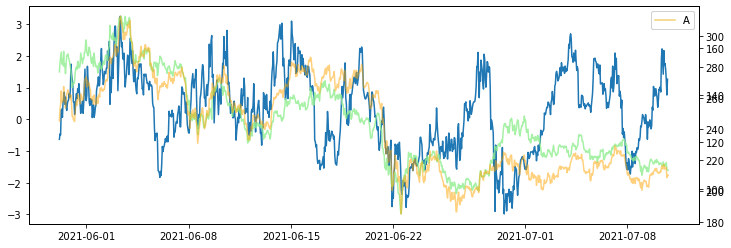

In [510]:
a = -1000
b = -1 #Not None
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(spread.zscore[a:b], alpha=1)
ax1 = ax.twinx()
ax1.plot(df["A"].loc[spread.index[a]:spread.index[b]], label="A", color="lightgreen", alpha=.8)
ax2 = ax.twinx()
ax2.plot(df["B"].loc[spread.index[a]:spread.index[b]], label="A", color="orange", alpha=.5)
ax1.legend()
ax2.legend()

In [511]:
spread = spread.dropna()

In [512]:
spread["A"] = df["A"].reindex(spread.index)
spread["B"] = df["B"].reindex(spread.index)

In [513]:
spread

,spread,mean,std,zscore,A,B
timestamp,,,,,,
2019-05-05 23:00:00,-24.439561,-26.347337,1.690814,1.128318,59.59,66.52
2019-05-06 00:00:00,-24.934826,-26.320326,1.691595,0.819050,59.60,66.04
2019-05-06 01:00:00,-25.511696,-26.297288,1.686708,0.465755,59.86,65.86
2019-05-06 02:00:00,-25.005395,-26.267551,1.682966,0.749959,60.00,66.58
2019-05-06 03:00:00,-25.003240,-26.241949,1.682527,0.736219,59.54,65.88
...,...,...,...,...,...,...
2021-07-10 15:00:00,46.434967,40.164638,4.007672,1.564581,110.51,215.12
2021-07-10 16:00:00,45.222792,40.200831,4.037033,1.243973,111.16,214.90
2021-07-10 17:00:00,43.329419,40.226658,4.048805,0.766340,108.26,208.58


In [514]:
total = 100.
fee = 0.002 #Set double normal rate
thres = 2 #2
sell_thres = 0 # 0, in range [0, ...)
cusum = []
price_a = None
price_b = None
long = None #Values: None, "A", "B"
long_a = []
long_b = []
liquidate = []
test = []
for i in range(spread.shape[0]):
    z = spread.zscore[i]
    if long == None: # Looking to buy
        if z>thres or z<-thres:
            price_a = [spread.A[i], ((total/2)/spread.A[i])*(1.-fee)]
            price_b = [spread.B[i], ((total/2)/spread.B[i])*(1.-fee)]
            if z>thres: 
                long = "B"
                long_b.append(spread.index[i])
            elif z<-thres:
                long = "A"
                long_a.append(spread.index[i])
    if long == "A" and z>sell_thres: #Liquidate positions
        total -= (spread.A[i] - price_a[0])*price_a[1]-(spread.A[0]*price_a[1]*fee)
        total -= (price_b[0] - spread.B[i])*price_b[1]-(spread.B[i]*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    elif long == "B" and z<-sell_thres: #Liquidate positions
        total -= (price_a[0] - spread.A[i])*price_a[1]-(spread.A[0]*price_a[1]*fee)
        total -= (spread.B[i] - price_b[0])*price_b[1]-(spread.B[i]*price_b[1]*fee)
        price_a, price_b, long = None, None, None
        liquidate.append(spread.index[i])
    cusum.append(total)

287.05478587646957


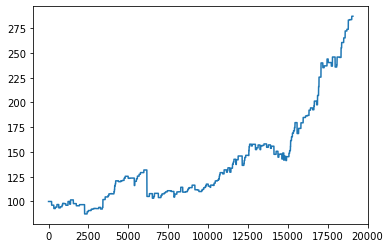

In [515]:
plt.plot(cusum);
print(total)

## Creating side

In [516]:
side_up = pd.Series(1, index=long_a)
side_down = pd.Series(-1, index=long_b)
side = pd.concat([side_up,side_down]).sort_index()
side

2019-05-08 00:00:00   -1
2019-05-15 13:00:00    1
2019-05-21 02:00:00   -1
2019-05-27 04:00:00   -1
2019-05-28 05:00:00    1
                      ..
2021-06-21 22:00:00    1
2021-06-27 19:00:00   -1
2021-06-28 23:00:00    1
2021-07-04 00:00:00   -1
2021-07-10 09:00:00   -1
Length: 189, dtype: int64

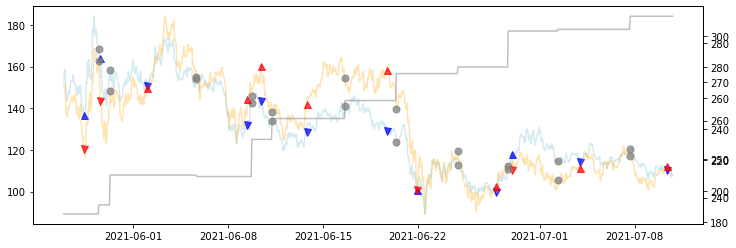

In [524]:
plot = spread
plot["cusum"] = cusum
plot = plot[18000:]

fig, ax = plt.subplots(figsize=(12,4))

# close_df.loc['2014':].plot(ax=ax, alpha=.5)
ax.plot(plot.A, alpha=.5, color="lightblue")
ax1 = ax.twinx()
ax1.plot(plot.B, alpha=.3, color="orange")


ax.plot(plot.A.reindex(long_a), marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='blue', linewidth=0)

ax.plot(plot.A.reindex(long_b), marker='v', markersize=7,
                     alpha=0.75, label='upcross', color='blue', linewidth=0)

ax1.plot(plot.B.reindex(long_b), marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='red', linewidth=0)

ax1.plot(plot.B.reindex(long_a), marker='v', markersize=7,
                     alpha=0.75, label='upcross', color='red', linewidth=0)
ax.plot(plot.A.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, label='upcross', color='gray', linewidth=0)
ax1.plot(plot.B.reindex(liquidate), marker='o', markersize=7,
                     alpha=0.75, label='upcross', color='gray', linewidth=0)
ax2 = ax.twinx()
ax2.plot(plot.cusum, color="gray", alpha=.5)
# ax.plot(plot.down, marker='v', markersize=7,
#                      alpha=0.75, label='upcross', color='r')




In [211]:
# cadf test
coint_t, pvalue, crit_value = ts.coint(df['B'], df['A'])
print('t-statistic=%f' % coint_t)
print('pvalue=%f' % pvalue)
print(crit_value)

t-statistic=-2.399272
pvalue=0.325200
[-3.89677187 -3.33631514 -3.04457851]


### GOOD CADFs
- ETH-XMR: -3.8
- ZEC-XMR: -3.4
- ETH-ADA: -5

In [519]:
# Johansen test
result = vm.coint_johansen(df[['A', 'B']].values, det_order=0, k_ar_diff=1)
print(result.lr1)
print(result.cvt)
print(result.lr2)
print(result.cvm)

[26.96147994  3.94548803]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[23.01599191  3.94548803]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [520]:
# Add IGE for Johansen test
result = vm.coint_johansen(df.values, det_order=0, k_ar_diff=1)
print(result.lr1)
print(result.cvt)
print(result.lr2)
print(result.cvm)

[26.96147994  3.94548803]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[23.01599191  3.94548803]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [521]:
print(result.eig)  # eigenvalues
print(result.evec)  # eigenvectors

[0.00162594 0.00027891]
[[ 0.05824813 -0.01086875]
 [-0.01526217 -0.0016142 ]]


<AxesSubplot:>

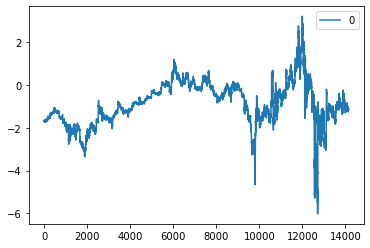

In [522]:
yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  # (net) market value of portfolio
yport.plot()

In [523]:
ylag = yport.shift()
deltaY = yport - ylag
df2 = pd.concat([ylag, deltaY], axis=1)
df2.columns = ['ylag', 'deltaY']
regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()  # Note this can deal with NaN in top row
print(regress_results.params)

Intercept   -0.003486
ylag        -0.004069
dtype: float64


In [524]:
halflife = -np.log(2) / regress_results.params['ylag']
print('halflife=%f days' % halflife)

halflife=170.359609 days


APR=0.018836 Sharpe=0.258590


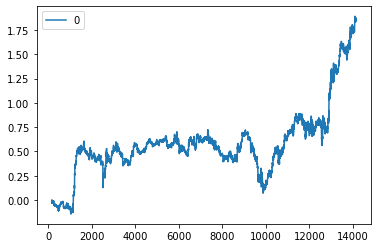

In [525]:
#  Apply a simple linear mean reversion strategy to EWA-EWC-IGE
lookback = np.round(halflife).astype(int)  # setting lookback to the halflife found above
numUnits = -(yport - yport.rolling(lookback).mean()) / yport.rolling(
    lookback).std()  # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
positions = pd.DataFrame(np.dot(numUnits.values, np.expand_dims(result.evec[:, 0],
                                                                axis=1).T) * df.values)  # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
pnl = np.sum((positions.shift().values) * (df.pct_change().values), axis=1)  # daily P&L of the strategy
ret = pnl / np.sum(np.abs(positions.shift()), axis=1)
pd.DataFrame((np.cumprod(1 + ret) - 1)).plot()
print('APR=%f Sharpe=%f' % (np.prod(1 + ret) ** (252 / len(ret)) - 1, np.sqrt(252) * np.mean(ret) / np.std(ret)))
# APR=0.125739 Sharpe=191310

## Co-integration brute-force tests

In [ ]:
# BTCUSDT
# ETHUSDT
# DOTUSDT
# ADAUSDT
# LTCUSDT
# ZECUSDT
# XMRUSDT
# ETCUSDT
# XLMUSDT
# BCHUSDT
# EOSUSDT
# DASHUSDT
# NANOUSDT

In [495]:
stats = pd.DataFrame(columns=["A", "B", "t", "p", "h"])

In [496]:
loc = ["BTCUSDT", "ETHUSDT", "DOTUSDT", "ADAUSDT", "LTCUSDT", "ZECUSDT", "XMRUSDT", "ETCUSDT", "XLMUSDT", "BCHUSDT"]

for a in loc:
    for b in loc[loc.index(a)+1:]:
        print(f"========== {a} and {b} ==========")
        df1 = pd.read_csv(f"../data/{a}-hour.csv", index_col=0, parse_dates=True)
        df2 = pd.read_csv(f"../data/{b}-hour.csv", index_col=0, parse_dates=True)
        df = df1.close.rename("A").to_frame()
        df["B"] = df2.close
        df = df[1000:]
        df = df.dropna()
        # cadf test
        coint_t, pvalue, crit_value = ts.coint(df['B'], df['A'])
        print(f"t-statistic={round(coint_t, 2)}, pvalue={round(pvalue, 2)}, crits={crit_value}")

        result = vm.coint_johansen(df[['A', 'B']].values, det_order=0, k_ar_diff=1)
        yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  # (net) market value of portfolio
        ylag = yport.shift()
        deltaY = yport - ylag
        df2 = pd.concat([ylag, deltaY], axis=1)
        df2.columns = ['ylag', 'deltaY']
        regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()
        halflife = -np.log(2) / regress_results.params['ylag']
        stats.append({"A":a, "B":b, "t":coint_t, "p":pvalue, "h":halflife}, ignore_index=True)
        print(f'halflife={round(halflife, 0)} days')
stats

========== BTCUSDT and ETHUSDT ==========
t-statistic=-2.4, pvalue=0.33, crits=[-3.89677187 -3.33631514 -3.04457851]
halflife=2197.0 days
========== BTCUSDT and DOTUSDT ==========
t-statistic=-2.97, pvalue=0.12, crits=[-3.8978432  -3.33691266 -3.04499323]
halflife=239.0 days
========== BTCUSDT and ADAUSDT ==========
t-statistic=-2.35, pvalue=0.35, crits=[-3.89682765 -3.33634626 -3.04460011]
halflife=1397.0 days
========== BTCUSDT and LTCUSDT ==========
t-statistic=-3.65, pvalue=0.02, crits=[-3.89679128 -3.33632597 -3.04458603]
halflife=821.0 days
========== BTCUSDT and ZECUSDT ==========
t-statistic=-2.95, pvalue=0.12, crits=[-3.89698287 -3.33643284 -3.04466021]
halflife=472.0 days
========== BTCUSDT and XMRUSDT ==========
t-statistic=-2.67, pvalue=0.21, crits=[-3.89697903 -3.3364307  -3.04465872]
halflife=540.0 days
========== BTCUSDT and ETCUSDT ==========
t-statistic=-3.17, pvalue=0.08, crits=[-3.89684698 -3.33635704 -3.04460759]
halflife=1104.0 days
========== BTCUSDT and XLMUSDT =

,A,B,t,p,h
